In [39]:
import numpy as np
from scipy import ndimage as ndi
import skimage
import os
import matplotlib.pyplot as plt


In [35]:
def overlay_mask(image, mask, color):

    outlines = skimage.segmentation.find_boundaries(mask)
    # plt.imshow(outlines)

    image_out = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)

    for c in range(3):
        curr_slice = (image - np.min(image))/(np.max(image) - np.min(image)) * 255
        curr_slice[outlines] = color[c] * 255
        image_out[:, :, c] = curr_slice

    return image_out
        
    

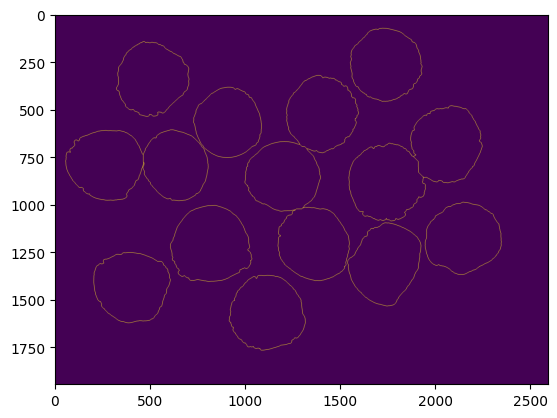

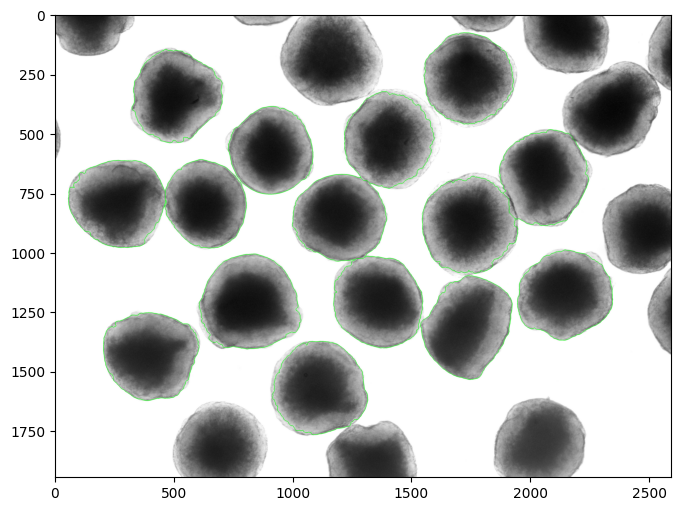

In [112]:
data_directory = '\\\\pn.vai.org\\projects\\wen\\vari-core-generated-data\\OIC\\OIC-234 EB Junwei\\EB8 image'

file = 'HET63-1 2X.tif'

image = skimage.io.imread(os.path.join(data_directory, file))
image = skimage.color.rgb2gray(image)

# Identify the EB cells
thresh = skimage.filters.threshold_otsu(image)

mask = image < (1.25 * thresh)

mask = skimage.morphology.binary_opening(mask, skimage.morphology.disk(10))
mask = skimage.morphology.remove_small_holes(mask, 200)

distance = ndi.distance_transform_edt(mask)
coords = skimage.feature.peak_local_max(distance, footprint=np.ones((3, 3)), labels=mask, threshold_abs=100, min_distance=50)
mask_marker = np.zeros(distance.shape, dtype=bool)
mask_marker[tuple(coords.T)] = True
markers, _ = ndi.label(mask_marker)
labels = skimage.segmentation.watershed(-distance, markers, mask=mask)

labels = skimage.segmentation.clear_border(labels)

labels = skimage.morphology.remove_small_objects(labels, 500)

ovimg = overlay_mask(image, labels, [0, 1, 0])

plt.figure(figsize=(8, 6))
plt.imshow(ovimg)

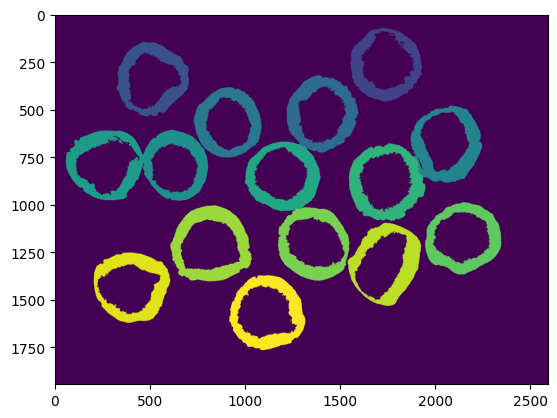

In [129]:
# For each cell, re-threshold maybe?

props = skimage.measure.regionprops(labels)

obj_labels = np.unique(labels)

inner_cell_labels = np.zeros(labels.shape, np.int32)

for obj in obj_labels:

    if obj == 0:
        continue
    else:
        intensities = image[labels == obj]

        # plt.figure()
        # plt.hist(intensities.ravel(), bins=30)
        thresh_cell = skimage.filters.threshold_otsu(intensities)

        curr_cell_label = np.zeros(labels.shape, np.bool)
        curr_cell_label[labels == obj] = True
        curr_cell_label[image < thresh_cell] = False

        curr_cell_label = skimage.morphology.remove_small_holes(curr_cell_label, 200)

        inner_cell_labels[curr_cell_label] = obj

plt.imshow(inner_cell_labels)

(array([1595., 9289., 7463., 6255., 5239., 3714., 3945., 3036., 2577.,
        2849., 2658., 2416., 2248., 2510., 2701., 3169., 3370., 3915.,
        4333., 4696., 5128., 4769., 3833., 3561., 3593., 3454., 2821.,
        2254., 1730.,  942.]),
 array([0.11459412, 0.13871618, 0.16283825, 0.18696031, 0.21108238,
        0.23520444, 0.25932651, 0.28344858, 0.30757064, 0.33169271,
        0.35581477, 0.37993684, 0.4040589 , 0.42818097, 0.45230303,
        0.4764251 , 0.50054716, 0.52466923, 0.54879129, 0.57291336,
        0.59703542, 0.62115749, 0.64527956, 0.66940162, 0.69352369,
        0.71764575, 0.74176782, 0.76588988, 0.79001195, 0.81413401,
        0.83825608]),
 <BarContainer object of 30 artists>)

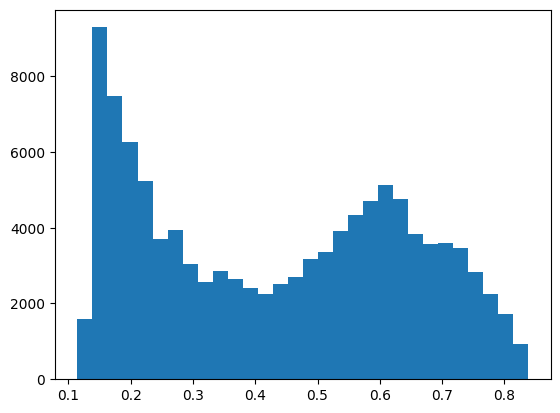

In [110]:
plt.figure()
plt.hist(intensities.ravel(), bins=30)

In [115]:
print(np.unique(labels))

[ 0  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20]


In [126]:
print(labels.dtype)

int32
